# Stock Price Forecaster 0.1b
## Machine Learning Engineer Nanodegree
**Calvin Ku**

**June 6, 2016**

## Definition

### Project Overview
This project is about building a stock price forecaster. I'm sure everybody knows what it means so I won't delve too much into explaining it. Initially I will make it a regressor, which means the forecaster is going to predict a number for a given stock for a given future date (say, the price of GOOGL 5 days from now). The goal of this project is to build the forecaster as "useful" as possible. By useful I mean that it is expected to be able to be used in real trading.

#### Data used in this project
The datasets I will use in this project are:
* Historical stock prices data
* St. Louis Fed Financial Stress Index data

For the historical data, we will use the stocks of S&P 500 (2009). Some of the stocks are not traded as of this writring so are excluded.

As said earlier, the goal is to make it as useful as possible. So in future iterations I will try to add more datasets for training, for example social data or search engine data to give it more predicting power.

### Problem Statement
Problem with trading is that you never know when is the best time to buy or sell a stock, as you never know if the stock price will go up or go down in the future. This simple forecaster is going to solve this problem for you.

To be more specific, for the stock you have in mind, the forecaster is going to predict the prices of that stock for dates that are 5/10/15/20 days from now.

To 

In this section, you will want to clearly define the problem that you are trying to solve, including the strategy (outline of tasks) you will use to achieve the desired solution. You should also thoroughly discuss what the intended solution will be for this problem. Questions to ask yourself when writing this section:

* Is the problem statement clearly defined? Will the reader understand what you are expecting to solve?
* Have you thoroughly discussed how you will attempt to solve the problem?
* Is an anticipated solution clearly defined? Will the reader understand what results you are looking for?

### Metrics
In this section, you will need to clearly define the metrics or calculations you will use to measure performance of a model or result in your project. These calculations and metrics should be justified based on the characteristics of the problem and problem domain. Questions to ask yourself when writing this section:

* Are the metrics you’ve chosen to measure the performance of your models clearly discussed and defined?
* Have you provided reasonable justification for the metrics chosen based on the problem and solution?

# Capstone Project
## Machine Learning Engineer Nanodegree
**Calvin Ku**

**July 15th, 2016**

## Definition
(approximately 1 - 2 pages)

### Project Overview
In this section, look to provide a high-level overview of the project in layman’s terms. Questions to ask yourself when writing this section:

* Has an overview of the project been provided, such as the problem domain, project origin, and related datasets or input data?
* Has enough background information been given so that an uninformed reader would understand the problem domain and following problem statement?

### Problem Statement

In this section, you will want to clearly define the problem that you are trying to solve, including the strategy (outline of tasks) you will use to achieve the desired solution. You should also thoroughly discuss what the intended solution will be for this problem. Questions to ask yourself when writing this section:

* Is the problem statement clearly defined? Will the reader understand what you are expecting to solve?
* Have you thoroughly discussed how you will attempt to solve the problem?
* Is an anticipated solution clearly defined? Will the reader understand what results you are looking for?

### Metrics
In this section, you will need to clearly define the metrics or calculations you will use to measure performance of a model or result in your project. These calculations and metrics should be justified based on the characteristics of the problem and problem domain. Questions to ask yourself when writing this section:

* Are the metrics you’ve chosen to measure the performance of your models clearly discussed and defined?
* Have you provided reasonable justification for the metrics chosen based on the problem and solution?

## Analysis
(approximately 2 - 4 pages)

### Data Exploration
In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:

* If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?
* If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?
* If a dataset is not present for this problem, has discussion been made about the input space or input data for your problem?
* Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)

### Exploratory Visualization
In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:

* Have you visualized a relevant characteristic or feature about the dataset or input data?
* Is the visualization thoroughly analyzed and discussed?
* If a plot is provided, are the axes, title, and datum clearly defined?

### Algorithms and Techniques
In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:

* Are the algorithms you will use, including any default variables/parameters in the project clearly defined?
* Are the techniques to be used thoroughly discussed and justified?
* Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?

### Benchmark
In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:

* Has some result or value been provided that acts as a benchmark for measuring performance?
* Is it clear how this result or value was obtained (whether by data or by hypothesis)?

## Methodology
(approximately 3 - 5 pages)

### Data Preprocessing
In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:

* If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?
* Based on the Data Exploration section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?
* If no preprocessing is needed, has it been made clear why?

### Implementation
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:

* Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?
* Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?
* Was there any part of the coding process (e.g., writing complicated functions) that should be documented?

### Refinement
In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:

* Has an initial solution been found and clearly reported?
* Is the process of improvement clearly documented, such as what techniques were used?
* Are intermediate and final solutions clearly reported as the process is improved?

## Results
(approximately 2 - 3 pages)

### Model Evaluation and Validation
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:

* Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?
* Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?
* Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?
* Can results found from the model be trusted?

### Justification
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:

* Are the final results found stronger than the benchmark result reported earlier?
* Have you thoroughly analyzed and discussed the final solution?
* Is the final solution significant enough to have solved the problem?

## Conclusion
(approximately 1 - 2 pages)

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:

* Have you visualized a relevant or important quality about the problem, dataset, input data, or results?
* Is the visualization thoroughly analyzed and discussed?
* If a plot is provided, are the axes, title, and datum clearly defined?

### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:

* Have you thoroughly summarized the entire process you used for this project?
* Were there any interesting aspects of the project?
* Were there any difficult aspects of the project?
* Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?

### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:

* Are there further improvements that could be made on the algorithms or techniques you used in this project?
* Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?
* If you used your final solution as the new benchmark, do you think an even better solution exists?

## Before submitting your report, ask yourself…
* Does the project report you’ve written follow a well-organized structure similar to that of the project template?
* Is each section (particularly Analysis and Methodology) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
* Would the intended audience of your project be able to understand your analysis, methods, and results?
* Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
* Are all the resources used for this project correctly cited and referenced?
* Is the code that implements your solution easily readable and properly commented?
* Does the code execute without error and produce results similar to those reported?

GOOGL
GOOGL
Index([u'GOOGL_Vol', u'GOOGL', u'GOOGL_Avg_Runup', u'GOOGL_return',
       u'GOOGL_Mean63d', u'GOOGL_Std63d', u'GOOGL_Cov63d', u'GOOGL_Beta',
       u'GOOGL_EMA', u'GOOGL_MMA', u'GOOGL_SMA', u'GOOGL_SMA_Momentum',
       u'GOOGL_Vol_Momentum', u'GOOGL_p_real1', u'GOOGL_p_real2',
       u'GOOGL_SR63d', u'STLFSI'],
      dtype='object')
{'normalize': False, 'copy_X': True, 'n_jobs': 1, 'fit_intercept': True}
LinearRegression
-612.590128698
0.913444083384


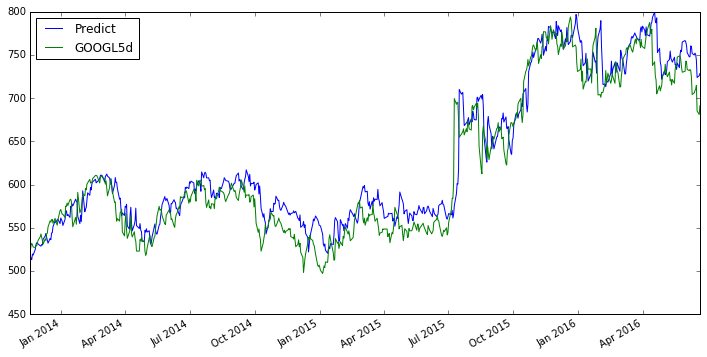

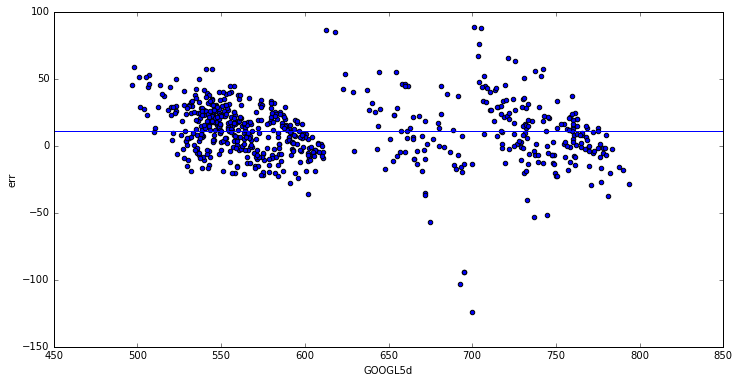

Err mean: 11.1600065434
2 * Std mean: 44.2173751731


In [42]:
from __future__ import division

%matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from os import getcwd
from pandas_datareader import data as web
from pandas_datareader._utils import RemoteDataError
from IPython.display import display
from datetime import date, datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn import grid_search
from sklearn.metrics import r2_score
import operator
from math import floor
# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.svm import SVR
from sklearn.cross_validation import LeaveOneOut, cross_val_score
from sklearn.tree import DecisionTreeRegressor
# Clustering/Dim Reduction
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', 200)

# Define date range
start_date = '2009-01-01'
end_date = '2016-06-30'
date_range = pd.date_range(start_date, end_date)
df_main = pd.DataFrame(index=date_range)

# Load SPY to get trading days
dfSPY = pd.read_csv('stock_data/SPY.csv', index_col='Date', parse_dates=True, usecols=['Date', 'Adj Close'], na_values = ['nan'])
dfSPY = dfSPY.rename(columns={'Adj Close': 'SPY'})
# Get SPY within the target date range
df_main = df_main.join(dfSPY)

# Drop NaN values
df_main = df_main.dropna()
# print(df_main)

# Load target stocks
dfSPY500_2009 = pd.read_csv('dev.csv', header=None, usecols = [1])
symbol = 'GOOGL'
# symbol = 'JEC'

df_temp = pd.read_csv('stock_data/' + symbol + '.csv', index_col="Date", parse_dates=True, usecols = ['Date', 'Volume', 'Adj Close'], na_values=['nan'])
df_temp = df_temp.rename(columns={'Volume': symbol + '_Vol', 'Adj Close': symbol})
df_temp.fillna(method='ffill', inplace=True)
df_temp.fillna(method='ffill', inplace=True)
df_main = df_main.join(df_temp, how='left')
    
###
### Feature Engineering Section
###
### Make Average Run-up Columns (252 days)
symbols = ['SPY']
symbols.append(symbol)
temp_dict = {}

for symbol in symbols:
    temp_dict[symbol] = []
    
    for i in df_main.index:
        (u,) = df_main.index.get_indexer_for([i])
        if u - 252 >= 0:
            temp_dict[symbol].append((df_main[symbol].iloc[u] - df_main[symbol].iloc[u - 252]) / 252)       
        else:
            temp_dict[symbol].append(np.nan)
            
    df_main[symbol + '_Avg_Runup'] = temp_dict[symbol]

### Make Daily Return Columns
def compute_daily_returns(df, adj_close_name):
    return (df / df.shift(1) - 1)[adj_close_name]

for symbol in symbols:
    df_main[symbol + '_return'] = compute_daily_returns(df_main, symbol)

### Make Beta columns (63 days)
mean_dict = {}
std_dict = {}

for symbol in symbols:
    mean_dict[symbol] = []
    std_dict[symbol] = []
    
    for i in df_main.index:
        (u,) = df_main.index.get_indexer_for([i])
        if u - 63 >= 0:
            mean_dict[symbol].append(df_main[symbol + '_return'].iloc[u - 63:u].mean())
            std_dict[symbol].append(df_main[symbol + '_return'].iloc[u - 63:u].std())
        else:
            mean_dict[symbol].append(np.nan)
            std_dict[symbol].append(np.nan)
    
    df_main[symbol + '_Mean63d'] = mean_dict[symbol]
    df_main[symbol + '_Std63d'] = std_dict[symbol]

cov_dict = {}

for symbol in symbols:
    cov_dict[symbol] = []
    for i in df_main.index:
        (u,) = df_main.index.get_indexer_for([i])
        if u - 63 >= 0:
            cov_dict[symbol].append(df_main['SPY_return'].iloc[(u - 63):u].cov(df_main[symbol + '_return'].iloc[(u - 63):u]))
        else:
            cov_dict[symbol].append(np.nan)
    df_main[symbol + '_Cov63d'] = cov_dict[symbol]
    df_main[symbol + '_Beta'] = df_main[symbol + '_Cov63d'] / df_main[symbol + '_Std63d']**2

### Make EMA column (100 days)
EMA_dict = {}
alpha = 2 / (100 + 1)

for symbol in symbols:
    EMA_dict[symbol] = []
    EMA_dict[symbol].append(df_main[symbol].iloc[0])
    
    for i in df_main.index[1:]:
        (u,) = df_main.index.get_indexer_for([i])
        EMA_dict[symbol].append(EMA_dict[symbol][u - 1] + alpha * (df_main[symbol].iloc[u] - EMA_dict[symbol][u - 1]))

    df_main[symbol + '_EMA'] = EMA_dict[symbol]

### Make MMA column (100 days)
MMA_dict = {}
alpha = 1 / 100

for symbol in symbols:
    MMA_dict[symbol] = []
    MMA_dict[symbol].append(df_main[symbol].iloc[0])
    
    for i in df_main.index[1:]:
        (u,) = df_main.index.get_indexer_for([i])
        MMA_dict[symbol].append(MMA_dict[symbol][u - 1] + alpha * (df_main[symbol].iloc[u] - MMA_dict[symbol][u - 1]))

    df_main[symbol + '_MMA'] = MMA_dict[symbol]
    
### Make SMA column (100 days)
for symbol in symbols:
    df_main[symbol + '_SMA'] = df_main[symbol].rolling(window=101, center=False).mean()

### SMA Momentum
def compute_SMA_momentum(df, SMA_column):
    return (df - df.shift(1))[SMA_column]*(100 + 1)

for symbol in symbols:
    df_main[symbol + '_SMA_Momentum'] = compute_SMA_momentum(df_main, symbol + '_SMA')

### Volume Momentum
def compute_Volume_momentum(df, Volume_column):
    return (df - df.shift(1))[SMA_column]*(100 + 1)

df_main[symbol + '_Vol_Momentum'] = compute_SMA_momentum(df_main, symbol + '_Vol')

### Momentum Real 1
df_main[symbol + '_p_real1'] = np.nan
df_main.loc[df_main[symbol + '_Vol_Momentum'] >= 0, symbol + '_p_real1'] = 1
df_main.loc[df_main[symbol + '_Vol_Momentum'] < 0, symbol + '_p_real1'] = 0

### Momentum Real 2
df_main[symbol + '_p_real2'] = np.nan
df_main.loc[df_main[symbol + '_Vol'] >= (df_main[symbol + '_Vol'].mean() + df_main[symbol + '_Vol'].std()), symbol + '_p_real2'] = 1
df_main.loc[df_main[symbol + '_Vol'] < (df_main[symbol + '_Vol'].mean() + df_main[symbol + '_Vol'].std()), symbol + '_p_real2'] = 0
# print(df_main)

### Make SR column
for symbol in symbols:
    df_main[symbol + '_SR63d'] = df_main[symbol + '_return'].rolling(window=63, center=False).mean() / df_main[symbol + '_Std63d']
    
# Load FSI data
dfFSI = pd.read_csv('STLFSI.csv', index_col='DATE', parse_dates=True, na_values = ['nan'])
df_main = df_main.join(dfFSI)
df_main['STLFSI'].fillna(method='ffill', inplace=True)
# print(df_main.describe())

df_main[symbol + '5d'] = df_main.shift(-5)[symbol]
df_main[symbol + '10d'] = df_main.shift(-10)[symbol]
df_main[symbol + '15d'] = df_main.shift(-15)[symbol]
df_main[symbol + '20d'] = df_main.shift(-20)[symbol]
# print(df_main[['GOOGL_return', 'GOOGL_SMA_Vol']])

print(symbol)
### Drop not-used columns
for column in df_main.columns:
    if 'SPY' in column:
        df_main.drop([column], axis=1, inplace=True)

print(symbol)
df_main.drop([symbol + '15d', symbol + '20d', symbol + '10d'], axis=1, inplace=True)

### Drop NaN columns
df_main.dropna(inplace=True)

data_X = df_main.drop([symbol + '5d'], axis=1)

print(data_X.columns)

## Feature Generation
# poly = PolynomialFeatures(2)
# data_X2 = poly.fit_transform(data_X)

# data_X2 = SelectKBest(chi2, k=2).fit_transform(data_X, data_y)

# data_X = pd.DataFrame(data_X2, index=data_X.index)


# Normalization
data_X = (data_X - data_X.mean()) / data_X.std()
data_y = df_main[symbol + '5d']

# data_X.drop([0], axis=1, inplace=True)
# print(data_X)
# print(data_y)

train_X = data_X.iloc[:int(floor(data_X.shape[0] * 0.6))]
train_y = data_y.iloc[:int(floor(data_y.shape[0] * 0.6))]
test_X = data_X.iloc[int(floor(data_X.shape[0] * 0.6)):]
test_y = data_y.iloc[int(floor(data_y.shape[0] * 0.6)):]

# pca = PCA(n_components = 15)
# pca.fit(data_X)
# reduced_data = pca.transform(data_X)
# reduced_data = pd.DataFrame(reduced_data)

# display(reduced_data)
# train_X = reduced_data.iloc[:int(floor(data_X.shape[0] * 0.6))]
# test_X = reduced_data.iloc[int(floor(data_X.shape[0] * 0.6)):]


lr = LinearRegression()
print(lr.__dict__)
print(lr.__class__.__name__)

# dtr = DecisionTreeRegressor()
# parameters = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}

# loo = cross_validation.LeaveOneOut(len(train_y))
# scores = cross_validation.cross_val_score(reg, train_X, train_y, scoring='mean_squared_error', cv=loo,)
# print(scores.mean())
parameters = {}
reg = grid_search.GridSearchCV(lr, parameters, cv=9, scoring='mean_squared_error')
# reg = grid_search.GridSearchCV(dtr, parameters, cv=4, scoring='r2')

# reg = RandomForestRegressor(n_estimators=300)
# reg = AdaBoostRegressor()
# reg = KNeighborsRegressor(n_neighbors=5)
# reg = SVR(C=1000)
reg.fit(train_X, train_y)
pred_y = reg.predict(test_X)
print(reg.score(test_X, test_y))
print(r2_score(test_y, pred_y))

### Checking residual plot
dfResult = pd.DataFrame(reg.predict(test_X), index=test_y.index, columns=['Predict']).join(test_y, )

# dfResult.ix[datetime(2015, 7, 1):datetime(2015, 9, 1)].plot(figsize=(12, 6))
# dfResult.ix[datetime(2014, 2, 1):datetime(2014, 3, 1)].plot(figsize=(12, 6))
dfResult.ix[:].plot(figsize=(12, 6))
# dfResult['dummy'] = range(len(dfResult))
# print(dfResult)
diff = (dfResult['Predict'] - dfResult[symbol + '5d']).to_frame()
diff = diff.join(dfResult[symbol + '5d'])
diff.columns = ['err', symbol + '5d']

diff.plot.scatter(x=symbol + '5d', y='err', figsize=(12, 6))
plt.axhline(y=diff['err'].mean())
plt.show()

print("Err mean: {}".format(diff['err'].mean()))
print("2 * Std mean: {}".format(2 * diff['err'].std()))


# plt.xlim(datetime(2014, 1, 1), datetime(2014, 2, 1))
# plt.show()

# plt.axis([np.datetime64('2014-01-01'), np.datetime64('2014-01-10'), 5, 5])
# plt.subplot(211)
# plt.plot(result['Date'], result['Adj Close'])

# plt.subplot(212)
# plt.plot(result['Date'], result['Predicted Label'])

# plt.show()


# plt.figure()
# plt.plot(reg.predict(test_X))
# plt.plot(test_y)
# plt.show()


# df2 = pd.read_csv('stock_data/' + 'GOOGL' + '.csv', index_col="Date", parse_dates=True, na_values=['nan'])
# df1 = df1.join(df2, how='inner')


# print(dfSPY.index)
# print(len(df1.index))

# df1 = df1.dropna()
# GOOGL = df1
# dfSPY = pd.read_csv('stock_data/SPY.csv', index_col=0, parse_dates=True)
# # Adjust stock prices to account for splits and dividends
# dfTemp = GOOGL.copy()

# dfTemp['Adj Open'] = (dfTemp['Adj Close'] / dfTemp['Close']) * dfTemp['Open']
# dfTemp['Adj High'] = (dfTemp['Adj Close'] / dfTemp['Close']) * dfTemp['High']
# dfTemp['Adj Low'] = (dfTemp['Adj Close'] / dfTemp['Close']) * dfTemp['Low']
# dfTemp['Adj Volume'] = (dfTemp['Adj Close'] / dfTemp['Close']) * dfTemp['Volume']

# dfTemp.drop(['Open', 'High', 'Low', 'Volume', 'Close'], axis=1, inplace=True)
# dfTemp = dfTemp[['Adj Open', 'Adj High', 'Adj Low', 'Adj Volume', 'Adj Close']]
# adjGOOGL = dfTemp
# # display(adjGOOGL)

# # print(adjGOOGL)
# # print(adjGOOGL.shift(1))
# # print((adjGOOGL / adjGOOGL.shift(1) - 1)['Adj Close'])
# def compute_daily_returns(df, adj_close_name):
#     df[adj_close_name + '_ret'] = (df / df.shift(1) - 1)[adj_close_name]
#     return df

# s1 = compute_daily_returns(dfSPY, 'Adj Close')['Adj Close_ret']
# s2 = compute_daily_returns(adjGOOGL, 'Adj Close')['Adj Close_ret']

# result = pd.concat([s1, s2], axis=1)
# print(result)


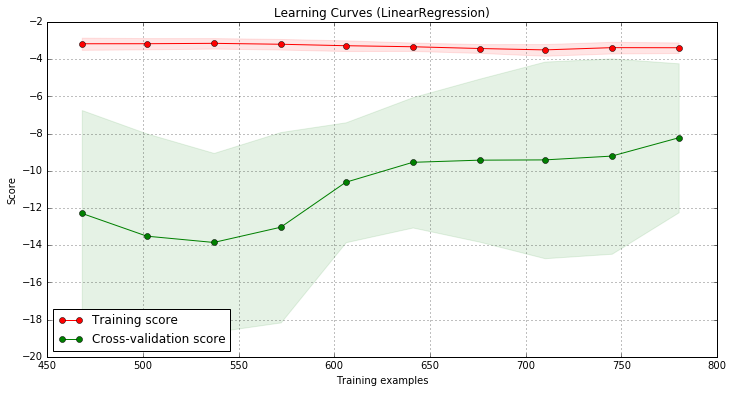

In [18]:
from sklearn import cross_validation
from sklearn.learning_curve import learning_curve
from data_visualizer.cross_validation import plot_learning_curve

# Linear Regression Learning Curve
title = "Learning Curves (LinearRegression)"
plot_learning_curve(reg, title, train_X, train_y, cv=5, n_jobs=1, train_sizes=np.linspace(.6, 1.0, 10))

plt.show()

Index([u'Symbol', u'Date', u'open_1d', u'high_1d', u'low_1d', u'volume_1d',
       u'adjclose_1d', u'open_3d_mean', u'high_3d_mean', u'low_3d_mean',
       ...
       u'low_1y_min', u'volume_1y_min', u'adjclose_1y_min', u'open_1y_std',
       u'high_1y_std', u'low_1y_std', u'volume_1y_std', u'adjclose_1y_std',
       u'Adj Close', u'RiseOrFall'],
      dtype='object', length=149)
0.862719723251


/Users/calvinku/anaconda/envs/udacity/lib/python2.7/site-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=5, top=5
  'bottom=%s, top=%s') % (bottom, top))


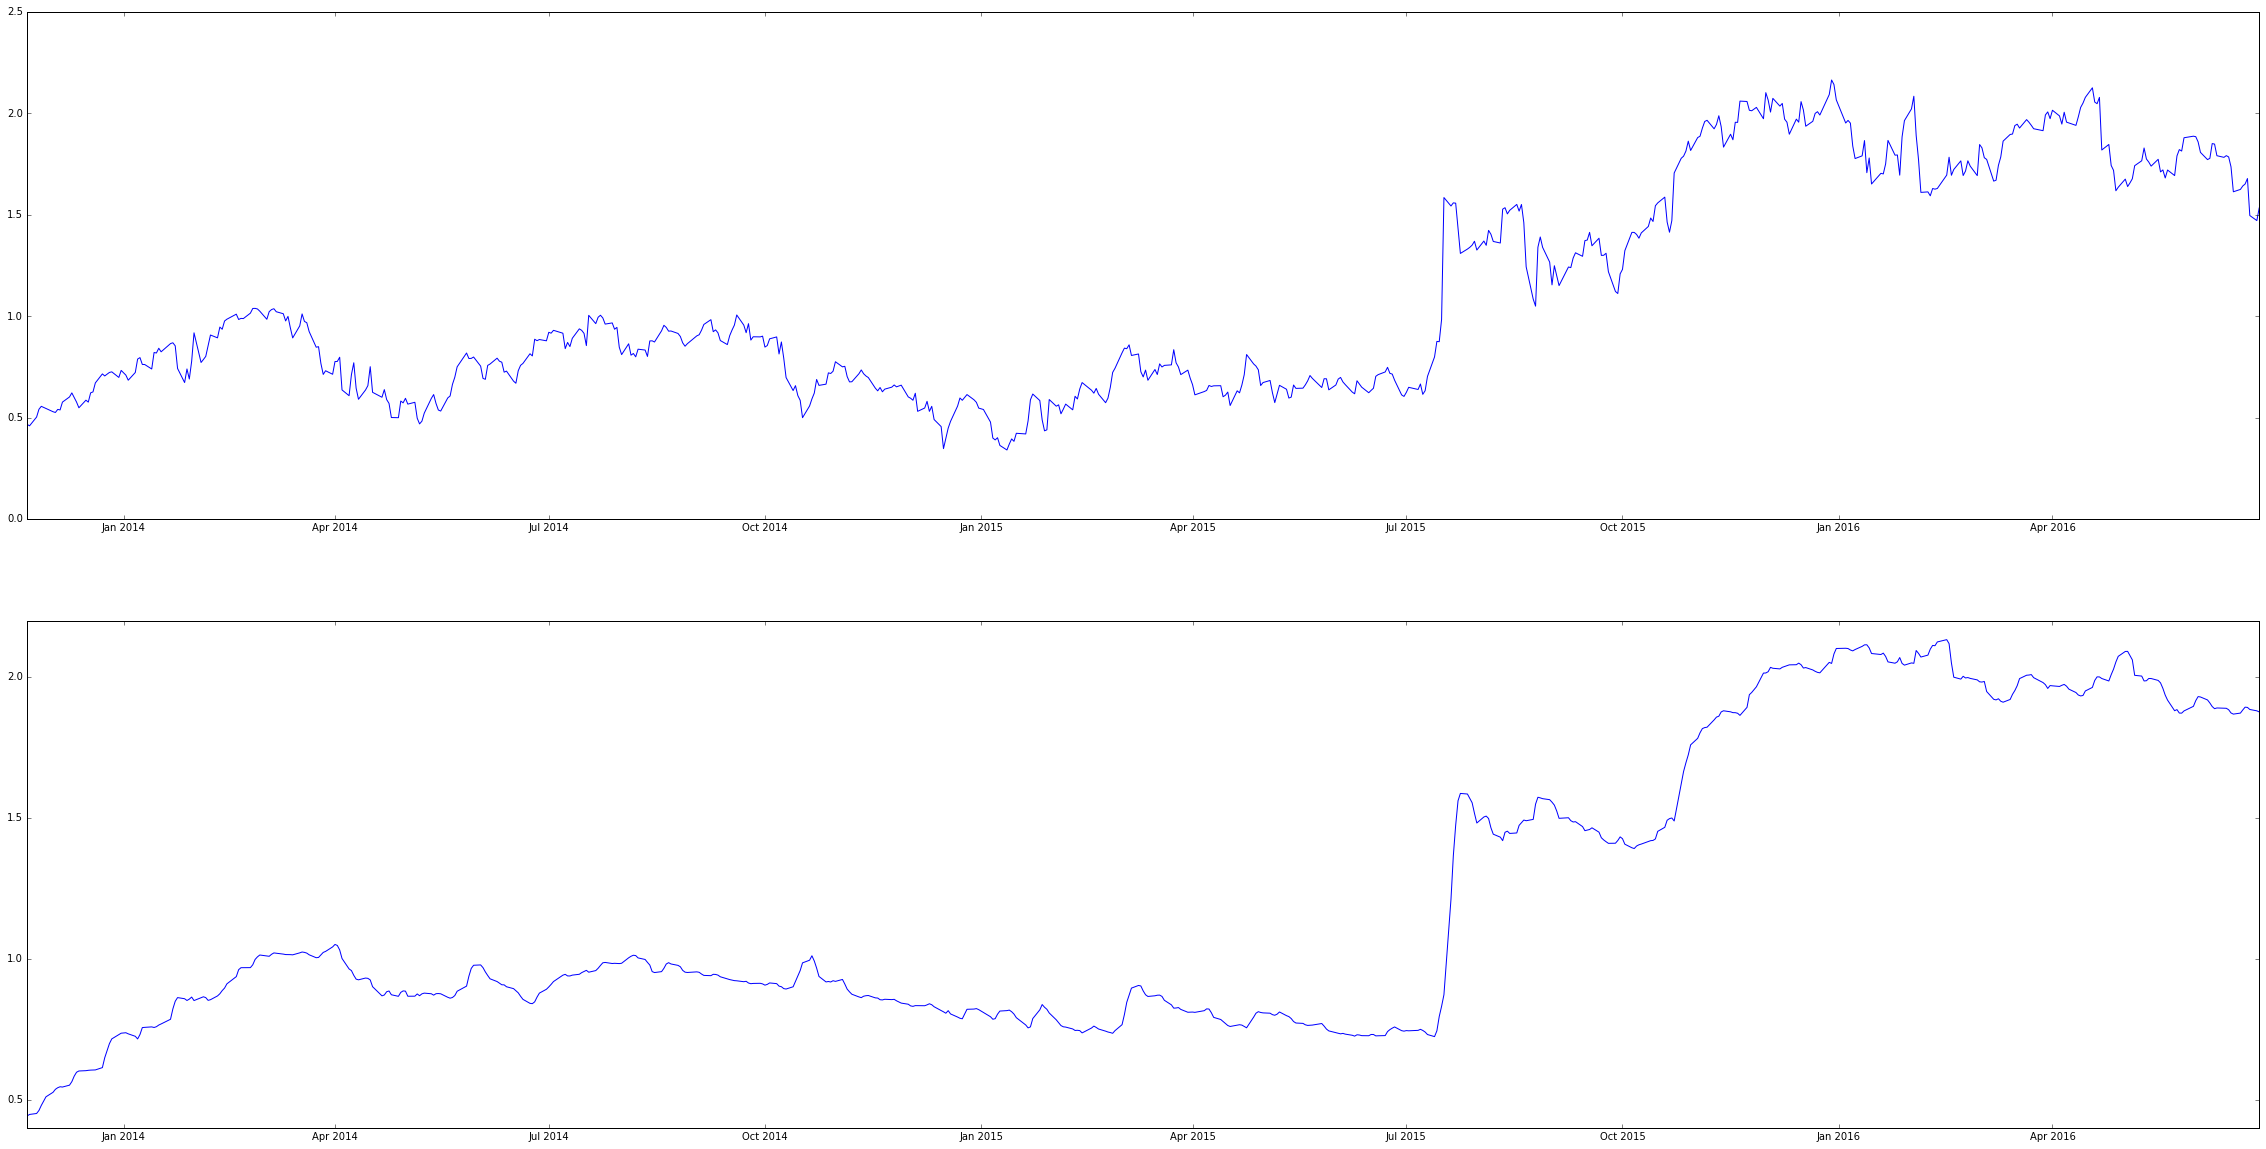

In [3]:
from math import floor

# Classifiers
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Clustering/Dim Reduction
from sklearn.decomposition import PCA

# Read in raw dataset
data = pd.read_csv('first.csv', index_col=0) # raw data

# Dataset X (feature)
# data_X = data.drop(['Symbol', 'Date', 'Adj Close', 'RiseOrFall'], axis=1) # drop labels for unsupervised learning
data_X = data.drop(['Symbol', 'Date', 'Adj Close', 'RiseOrFall', 'open_1d', 'high_1d', 'low_1d', 'volume_1d', 'adjclose_1d', \
        'open_3d_mean', 'high_3d_mean', 'low_3d_mean', 'volume_3d_mean', 'adjclose_3d_mean', \
        'open_3d_max', 'high_3d_max', 'low_3d_max', 'volume_3d_max', 'adjclose_3d_max', \
        'open_3d_min', 'high_3d_min', 'low_3d_min', 'volume_3d_min', 'adjclose_3d_min', \
        'open_3d_std', 'high_3d_std', 'low_3d_std', 'volume_3d_std', 'adjclose_3d_std', \
        'open_5d_mean', 'high_5d_mean', 'low_5d_mean', 'volume_5d_mean', 'adjclose_5d_mean', \
        'open_5d_max', 'high_5d_max', 'low_5d_max', 'adjclose_5d_max', 'volume_5d_max', \
        'open_5d_min', 'high_5d_min', 'low_5d_min', 'adjclose_5d_min', 'volume_5d_min', \
        'open_5d_std', 'high_5d_std', 'low_5d_std', 'adjclose_5d_std', 'volume_5d_std'], axis=1) # drop labels for unsupervised learning
print(data.columns)

# Normalization
data_X = (data_X - data_X.mean()) / data_X.std()

y_mean = data['Adj Close'].mean()
y_std = data['Adj Close'].std()
data_y = (data['Adj Close'] - y_mean) / y_std

train_X = data_X.iloc[:int(floor(data_X.shape[0] * 0.6))]
train_y = data_y.iloc[:int(floor(data_y.shape[0] * 0.6))]
test_X = data_X.iloc[int(floor(data_X.shape[0] * 0.6)):]
test_y = data_y.iloc[int(floor(data.shape[0] * 0.6)):]

pca = PCA(n_components = 2)
pca.fit(data_X)
reduced_data = pca.transform(data_X)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

# display(reduced_data)
train_X = reduced_data.iloc[:int(floor(data_X.shape[0] * 0.6))]
test_X = reduced_data.iloc[int(floor(data_X.shape[0] * 0.6)):]

# display(train_X.describe())

reg = LinearRegression()
reg.fit(train_X, train_y)

# plt.plot(reg.predict(test_X), data.ix[int(floor(data_X.shape[0] * 0.6)):, 'Date'])
# plt.show()
print(reg.score(test_X, test_y))


label = test_y.reset_index()
del label['index']

pred_label = pd.DataFrame(reg.predict(test_X), columns=['Predicted Label'])
pred_date = data.ix[int(floor(data_X.shape[0] * 0.6)):, 'Date']
test = pd.Series(pred_date).reset_index().drop(['index'], axis=1)


result = pd.concat([pred_label, test, label], axis=1, join='inner')

# print(result)

result['Date'] = result['Date'].apply(np.datetime64)

# print(result.describe())

plt.figure(1, figsize=(40,20))
plt.axis([np.datetime64('2014-01-01'), np.datetime64('2014-01-10'), 5, 5])
plt.subplot(211)
plt.plot(result['Date'], result['Adj Close'])

plt.subplot(212)
plt.plot(result['Date'], result['Predicted Label'])

plt.show()

In [4]:
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import operator

scores = {}

for n in range(2, 11):
    clusterer = KMeans(n_clusters = n)
    clusterer.fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    labels = clusterer.labels_
    score = silhouette_score(reduced_data, labels, metric='euclidean')
    scores[n] = score
    
    print "Silhouette score with n = {}: {}".format(n, score)

max_key = max(scores.keys(), key=(lambda k: scores[k])) 

clusterer = KMeans(n_clusters = max_key)
clusterer.fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
centers = clusterer.cluster_centers_

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
labels = clusterer.labels_
score = silhouette_score(reduced_data, labels, metric='euclidean')
        
print "Cluster centers: \n{}\n".format(centers)
print "Silhouette score (max) with n = {}: {}".format(max_key, score)
centers = clstr.cluster_centers_


Silhouette score with n = 2: 0.641890238159
Silhouette score with n = 3: 0.61481252838
Silhouette score with n = 4: 0.549415309406
Silhouette score with n = 5: 0.555679025243
Silhouette score with n = 6: 0.513126957186
Silhouette score with n = 7: 0.461960885108
Silhouette score with n = 8: 0.466469733849
Silhouette score with n = 9: 0.46420739099
Silhouette score with n = 10: 0.456410025011
Cluster centers: 
[[ 9.17365052 -0.04283566]
 [-6.46368904  0.0301817 ]]

Silhouette score (max) with n = 2: 0.641890238159


NameError: name 'clstr' is not defined

In [ ]:
import renders as rs
rs.cluster_results(reduced_data, preds, centers, centers)

In [ ]:
import numpy as np
from scipy.signal import lfilter

df = pd.DataFrame([1, 7, 9, 5], columns=['A'])
df['B'] = lfilter([1], [1, -2], df['A'].astype(float))

df

In [ ]:
2**2